# Gaussian Imputation

Sample from a multivariate normal distribution generated using random mean and covariance.
Use `gaussian imputer` to update randomly removed values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def hinton_diagram(matrix, *, max_weight=None, ax=None, title=None, figsize=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    if max_weight is None:
        max_weight = np.exp2(np.ceil(np.log2(np.nanmax(np.abs(matrix)))))

    ax.patch.set_facecolor('white')
    for (x, y), w in np.ndenumerate(matrix):
        if np.isnan(w):
            continue
        color = 'lawngreen' if w > 0 else 'royalblue'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = Rectangle(
            (x - size / 2, y - size / 2), # xy : (float, float)
            size, # width : float
            size, # height : float
            facecolor=color, edgecolor=color
        )
        ax.add_patch(rect)

    if title is not None:
        ax.set_title(title)
    ax.set(xlabel='Sample number', ylabel='Dimension of data')

    nr, nc = matrix.shape    
    ax.set_xticks(np.arange(0, nr))
    ax.set_yticks(np.arange(0, nc))
    ax.invert_yaxis()
    
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.8)
    ax.set_aspect('equal', 'box')
    ax.autoscale_view() # autoscale the view limits using the data limits

    return ax


In [2]:
data_dim = 10
# number of samples
sample_size = 20
# threshold to hide values
threshold_missing = 0.5

# Generate mean for multivariate gaussian
rng = np.random.default_rng()
mean = rng.normal(size=data_dim)

# Generate a random symmetric, positive-definite matrix
# based on `skleran.datasets.make_spd_matrix`
def make_spd_matrix(n_dim, *, random_generator=None):
    if random_generator is None:
        random_generator = np.random.default_rng()
    A = random_generator.uniform(size=(n_dim, n_dim))
    U, _, Vt = np.linalg.svd(np.dot(A.T, A))
    X = np.dot(np.dot(U, 1.0 + np.diag(random_generator.uniform(size=n_dim))), Vt)
    # Test if the matrix is positive definite
    assert np.all(np.linalg.eigvals(X) > 0)
    return X
cov = make_spd_matrix(data_dim, random_generator=rng)

mean.shape, cov.shape

((10,), (10, 10))

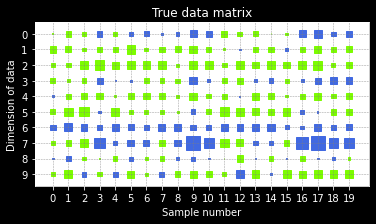

In [3]:
# Generate true data matrix
x_true = rng.multivariate_normal(mean, cov, size=sample_size)
hinton_diagram(x_true, title='True data matrix');

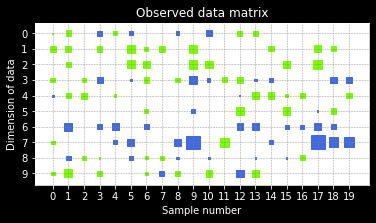

In [4]:
# Randomly adding nan values to true data matrix to create observed data matrix
missing_idx = rng.random(size=(sample_size, data_dim)) < threshold_missing
x_observed = x_true.copy()
x_observed[missing_idx] = np.nan
hinton_diagram(x_observed, title='Observed data matrix');

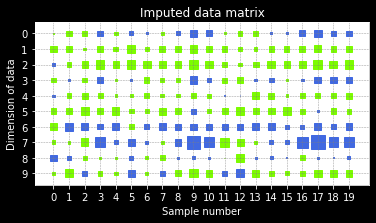

In [5]:
# Compute conditional Gaussian p(y_h|y_v) = N(y_h | mu_hv, sigmma_hv)
# where  mu_hv = mu_h + sigma_hv @ sigma_vv_inv @ (y_v - mu_v)
# and sigma_hv = sigma_hh - sigma_hv @ sigma_vv_inv @ sigma_vh 
# (See 3.2.3 Marginals and conditionals of an MVN)
def gauss_conditional(mu, sigma, visible_nodes, visible_values):
    """
    mu : ndarray 1d, (mu_h, mu_v)
    sigma: ndarray 2d (sigma_hh & sigma hv \\ sigma_vh & sigma_vv)
    visible_nodes: ndarray 1d, indices of y_v
    visible_values: ndarray 1d, values of y_v

    mugivh: ndarray 1d, mu_hv
    sigivh: ndarray 2d, sigma_hv
    """
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)

    v = set(visible_nodes)
    assert len(v) == len(visible_values)
    h = list(set(range(mu.shape[0])) - v)
    assert len(h) > 0
    v = list(v)
    assert len(v) < mu.shape[0]

    if len(v) == 0: # no visible
        return mu, sigma
    
    sigma_hh = sigma[np.ix_(h, h)]
    sigma_hv = sigma[np.ix_(h, v)]
    sigma_vv = sigma[np.ix_(v, v)]
    sigma_vv_inv = np.linalg.inv(sigma_vv)

    mu_hv = mu[h] + sigma_hv @ sigma_vv_inv @ (visible_values - mu[v])
    sigma_hv = sigma_hh - sigma_hv @ sigma_vv_inv @ sigma_hv.T
    return mu_hv, sigma_hv

# Imputing missing/nan values to create imputed data matrix
x_imputed = x_observed.copy()
for i, sample in enumerate(x_observed):
    mask = np.isnan(sample)
    hidden_nodes = np.nonzero(mask)[0]
    visible_nodes = np.nonzero(~mask)[0]
    visible_values = sample[visible_nodes]
    x_imputed[i, mask] = gauss_conditional(mean, cov, visible_nodes, visible_values)[0]
hinton_diagram(x_imputed, title='Imputed data matrix');

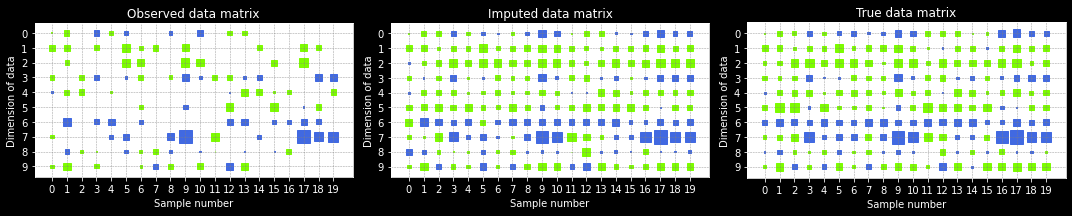

In [6]:
max_weight = np.exp2(np.ceil(np.log2(np.nanmax(np.abs(x_true)))))

fig, axes = plt.subplots(ncols=3, figsize=(15,5))
hinton_diagram(x_observed, max_weight=max_weight, ax=axes[0], title='Observed data matrix')
hinton_diagram(x_imputed, max_weight=max_weight, ax=axes[1], title='Imputed data matrix')
hinton_diagram(x_true, max_weight=max_weight, ax=axes[2], title='True data matrix')
fig.tight_layout()